In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random

In [32]:
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Dropout,BatchNormalization,Input,GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.keras import regularizers
from keras.models import load_model

#### Loading Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [29]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
label_name = dict({0:'Airplane',1:'automobile', 2: 'Bird', 3: 'cat', 4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'})

In [5]:
print("Training size",x_train.shape)
print("Test size",x_test.shape)

Training size (50000, 32, 32, 3)
Test size (10000, 32, 32, 3)


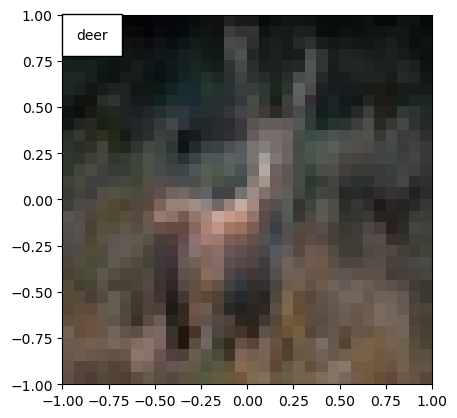

array([4], dtype=uint8)

In [6]:
choice = random.randint(0,len(x_train)) 
fig, ax = plt.subplots(1)
plt.imshow(x_train[choice],extent=[-1, 1, -1, 1])
ax.text(-0.925,0.87, label_name[y_train[choice][0]], bbox={'facecolor': 'white', 'pad': 10})
plt.show()
y_train[choice]

In [7]:
TRAIN_SIZE = 32
amount = 0.2

In [8]:
def add_noise(images, amount=0.2):
    '''
    Given an array of images in a shape (None, Height, Width, Channels),
    this function adds gaussian noise to every channel of the image
    '''
    #creating a matrix for inducing noise in all the channels
    noise = np.random.normal(0,amount,images.shape[0]*images.shape[1]*images.shape[2]
                            *images.shape[3]).reshape(images.shape)
    #adding noise to images
    noisy_img = images+noise 
    noisy_img = np.clip(noisy_img, 0., 1.)
    return noisy_img

In [9]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_train_noisy = add_noise(x_train,amount)
x_test_noisy = add_noise(x_test,amount)

Text(0.5, 1.0, 'Noisy Image')

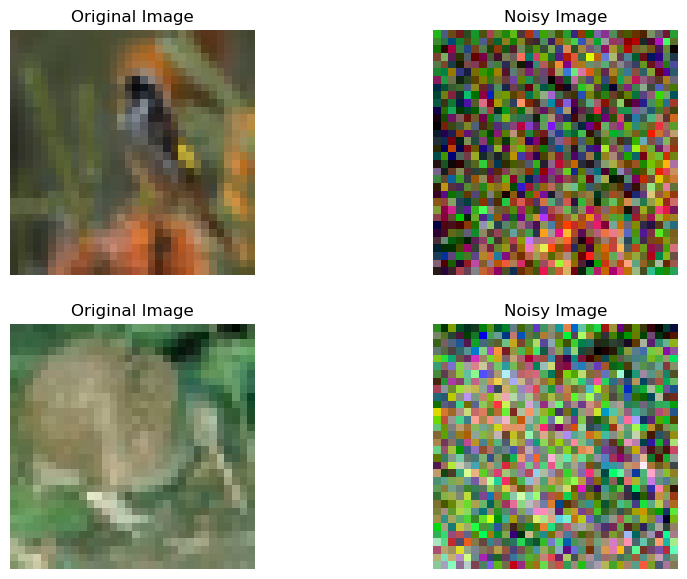

In [10]:
# create figure
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 2
columns = 2
# reading images
choice1 = random.randint(0,len(x_train))
choice2 = random.randint(0,len(x_train))
Image1 = x_train[choice1]
Image2 = x_train_noisy[choice1]
Image3 = x_train[choice2]
Image4 = x_train_noisy[choice2]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Noisy Image")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Noisy Image")

#### 6. Model Building

In [11]:
start = Input(shape=(TRAIN_SIZE,TRAIN_SIZE,3),dtype=tf.float32)
#to make the model accept variable size inputs, we set the input shape parameter to (None,None,3)

##### Constructing U-Net Architecture

In [12]:
#Encoder
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(start)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(c1)
c1 = BatchNormalization()(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
p1 = tf.keras.layers.Dropout(0.1)(p1)

In [13]:
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(p1)
c2 = BatchNormalization()(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(c2)
c2 = BatchNormalization()(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)
p2 = tf.keras.layers.Dropout(0.2)(p2)

In [14]:
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(p2)
c3 = BatchNormalization()(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(c3)
c3 = BatchNormalization()(c3)

In [15]:
u4 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same",activity_regularizer=regularizers.l2(10e-8))(c3)
u4=tf.keras.layers.concatenate([u4,c2])
u4=tf.keras.layers.Dropout(0.2)(u4)
c4=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(u4)
c4 = BatchNormalization()(c4)
c4=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(c4)
c4 = BatchNormalization()(c4)

In [16]:
u5=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same",activity_regularizer=regularizers.l2(10e-8))(c4)
u5=tf.keras.layers.concatenate([u5,c1])
u5=tf.keras.layers.Dropout(0.1)(u5)
c5=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(u5)
c5 = BatchNormalization()(c5)
c5=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same",activity_regularizer=regularizers.l2(10e-8))(c5)
c5 = BatchNormalization()(c5)

In [17]:
outputs=tf.keras.layers.Conv2D(3,(1,1),activation="sigmoid")(c5)

In [18]:
model_cifar=tf.keras.Model(inputs=[start],outputs=[outputs])
model_cifar.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),loss="mse", metrics=[tf.keras.metrics.MeanSquaredError()])
model_cifar.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   2320        ['batch_normalization[0][0]']

__________________________________________________________________________________________________


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Callback functions

In [19]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./model_cifar_10.h5",verbose=1,save_best_only=True)

In [20]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=7,monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

#### Train Model

In [21]:
history = model_cifar.fit(x_train_noisy,x_train,validation_split=0.2,batch_size=16,epochs=40,callbacks=callbacks)

Epoch 1/40
2498/2500 [============================>.] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0086
Epoch 1: val_loss improved from inf to 0.00660, saving model to .\model_cifar_10.h5
2500/2500 [==============================] - 60s 21ms/step - loss: 0.0115 - mean_squared_error: 0.0086 - val_loss: 0.0066 - val_mean_squared_error: 0.0052
Epoch 2/40
2500/2500 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0060
Epoch 2: val_loss improved from 0.00660 to 0.00544, saving model to .\model_cifar_10.h5
2500/2500 [==============================] - 69s 28ms/step - loss: 0.0068 - mean_squared_error: 0.0060 - val_loss: 0.0054 - val_mean_squared_error: 0.0047
Epoch 3/40
2500/2500 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0056
Epoch 3: val_loss improved from 0.00544 to 0.00523, saving model to .\model_cifar_10.h5
2500/2500 [==============================] - 69s 28ms/step - loss: 0.0060 - mean_squared_error: 0.0056 - v

#### Evaluate Model

In [22]:
model_cifar.evaluate(x_test_noisy,x_test,batch_size=16)

625/625 [==============================] - 9s 14ms/step - loss: 0.0241 - mean_squared_error: 0.0052


[0.024111103266477585, 0.005158257205039263]

#### Result

In [42]:
#model_cifar_10 = load_model('model_cifar_10.h5')

1/1 [==============================] - 0s 29ms/step


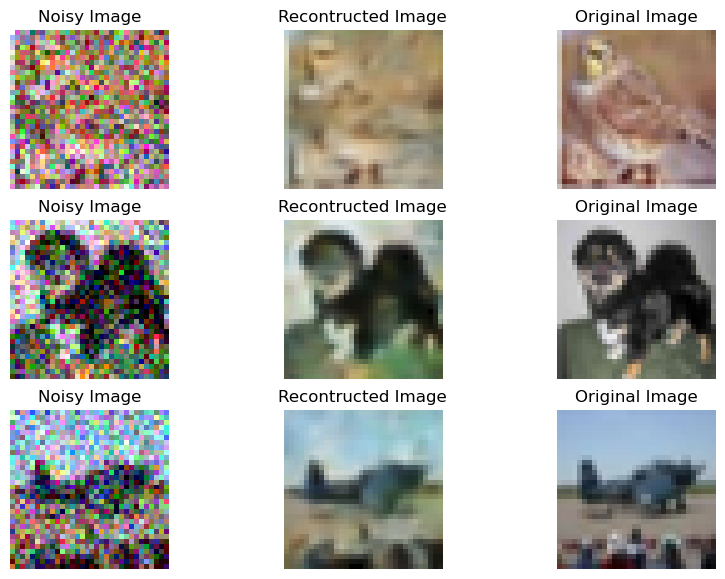

In [43]:
fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 3
# reading images
choice1 = random.randint(0,len(x_test))
choice2 = random.randint(0,len(x_test))
choice3 = random.randint(0,len(x_test))
Image3 = x_test[choice1]
Image6 = x_test[choice2]
Image9 = x_test[choice3]
amount=0.05
Image1 = x_test_noisy[choice1]
Image4 = x_test_noisy[choice2]
Image7 = x_test_noisy[choice3]
Image2= np.expand_dims(Image1, axis=0)
Image2 = model_cifar.predict(Image2)
Image2= np.squeeze(Image2)
Image5= np.expand_dims(Image4, axis=0)
Image5 = model_cifar.predict(Image5)
Image5= np.squeeze(Image5)
Image8= np.expand_dims(Image7, axis=0)
Image8 = model_cifar.predict(Image8)
Image8= np.squeeze(Image8)
# Adds a subplot at the 1st Image
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title("Noisy Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title("Recontructed Image")
fig.add_subplot(rows, columns, 3) 
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 2st Image
fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title("Noisy Image")
fig.add_subplot(rows, columns, 5)
plt.imshow(Image5)
plt.axis('off')
plt.title("Recontructed Image")
fig.add_subplot(rows, columns, 6) 
plt.imshow(Image6)
plt.axis('off')
plt.title("Original Image")

# Adds a subplot at the 2st Image
fig.add_subplot(rows, columns, 7)
plt.imshow(Image7)
plt.axis('off')
plt.title("Noisy Image")
fig.add_subplot(rows, columns, 8)
plt.imshow(Image8)
plt.axis('off')
plt.title("Recontructed Image")
fig.add_subplot(rows, columns, 9) 
plt.imshow(Image9)
plt.axis('off')
plt.title("Original Image")
plt.show()